In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Copyright [2020] [Indian Institute of Science, Bangalore]
SPDX-License-Identifier: Apache-2.0
"""
__name__ = "Instantiate a city and dump instantiations as json"

import os, sys
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time

#Data-processing Functions
from modules.processDemographics import *
from modules.processGeoData import *

# Functions to instantiate individuals to houses, schools, workplaces and community centres
from modules.assignHouses import *
from modules.assignSchools import *
from modules.assignWorkplaces import *


city = "bangalore"
targetPopulation = 10000
averageStudents = 17
averageWorkforce = 2

## Processing Data files

In [2]:
#create directory to store parsed data
if not os.path.exists("data/"+city):
    os.mkdir("data/"+city)   

print("processing data ready ...")
start = time.time()
cityGeojson = "data/base/"+city+"/city.geojson"
cityGeoDF = parse_geospatial_data(cityGeojson)


if "cityProfile.json" in os.listdir("data/base/"+city):
    cityProfile = "data/base/"+city+"/cityProfile.json"
    ageDistribution, householdDistribution, schoolDistribution, householdSizes, unemployed_fraction, maxWorkplaceDistance = process_city_profile(cityProfile)

demographicsData = pd.read_csv("data/base/"+city+"/demographics.csv")
housesData = pd.read_csv("data/base/"+city+"/households.csv")
employmentData = pd.read_csv("data/base/"+city+"/employment.csv")
print("processing data completed completed in ", time.time() - start)

processing data ready ...
processing data completed completed in  6.057482481002808


## Computing additional parameters

In [3]:
print("getting parameters ready ...")
start = time.time()
demographicsData = process_data(demographicsData, housesData, employmentData, targetPopulation, ageDistribution) 

totalPopulation = demographicsData['totalPopulation'].values.sum()
if unemployed_fraction == 0:
    people_over_60 = float(demographicsData[['age 60-64']].sum()) + float(demographicsData[['age 65-69']].sum()) + float(demographicsData[['age 70-74']].sum()) + float(demographicsData[['age 75-79']].sum()) + float(demographicsData[['age 80+']].sum())

    population_over_60 = totalPopulation * (people_over_60/ totalPopulation)
    total_employable = (float(demographicsData[['age 15-19']].sum())+\
                                                    float(demographicsData[['age 20-24']].sum()))+\
                                                    float(demographicsData[['age 25-29']].sum())+\
                                                    float(demographicsData[['age 30-34']].sum())+\
                                                    float(demographicsData[['age 35-39']].sum())+\
                                                    float(demographicsData[['age 40-44']].sum())+\
                                                    float(demographicsData[['age 45-49']].sum())+\
                                                    float(demographicsData[['age 50-54']].sum())+\
                                                    float(demographicsData[['age 55-59']].sum())

    employable_population = totalPopulation * ((total_employable/totalPopulation)) + ((float(demographicsData[['age 15-19']].sum())/totalPopulation) * 0.5)

    total_unemployed = demographicsData['unemployed'].values.sum()
    unemployed_but_employable = total_unemployed - population_over_60
    unemployed_fraction = unemployed_but_employable  / (totalPopulation - population_over_60)

# print(people_over_60, unemployed_fraction, employable_population, total_employable, total_unemployed, unemployed_but_employable )

totalNumberOfWards = len(demographicsData['wardNo'].values)
averageHouseholds = totalPopulation / demographicsData['totalHouseholds'].values.sum()

commonArea = commonAreaLocation(cityGeoDF)
print("getting parameters ready completed in ", time.time() - start)


getting parameters ready ...
getting parameters ready completed in  0.478851318359375


## Assignment of individuals to households

In [4]:
#assignment of individuals to households
print("instantiating individuals to households...")
start = time.time()
print("computed unemployment fraction = ", unemployed_fraction)
households, individuals = assign_individuals_to_houses(targetPopulation, totalNumberOfWards, ageDistribution, householdSizes, householdDistribution, unemployed_fraction)
print("instantiating individuals to households completed in ", time.time() - start)

print("instantiating individual location by house location...")
start = time.time()
households, individuals = houseLocation(cityGeoDF, individuals, households)
print("instantiating individual location by house location completed in ", time.time() - start)

instantiating individuals to households...
computed unemployment fraction =  0.46826047577725327
instantiating individuals to households completed in  23.055346250534058
instantiating individual location by house location...
instantiating individual location by house location completed in  0.6386451721191406


## Assigning individuals to workplaces and schools

In [5]:
#split the individuals by workplace type
individuals = {name: individuals.loc[individuals['workplaceType'] == name, :] for name in individuals['workplaceType'].unique()}

print("instantiating individuals to workplaces...")
start = time.time()
workplaces, individuals[1] = assign_workplaces(cityGeoDF, individuals[1], maxWorkplaceDistance)
print("instantiating individuals to workplaces completed in ", time.time() - start)

instantiating individuals to workplaces...
instantiating individuals to workplaces completed in  31.426000118255615


In [6]:
print("instantiating individuals to schools...")
start = time.time()
individuals[2], schools = assign_schools(individuals[2], cityGeoDF,  schoolDistribution)
print("instantiating individuals to schools completed in ", time.time() - start)

instantiating individuals to schools...
instantiating individuals to schools completed in  4.461597442626953


## additonal processing based on demographics data

In [7]:
print("additonal data processing...")
start = time.time()

#join the individuals
individuals = pd.concat(individuals.values(), ignore_index=True)

#associate individuals to common areas (by distance) and categorize workplace Type
def getDistances(row, cc):
    findCommunityCentre = cc[int(row["wardIndex"])]

    lat1 = row['lat']
    lon1 = row['lon']

    lat2 = findCommunityCentre[1]
    lon2 = findCommunityCentre[0]

    return distance(lat1, lon1, lat2, lon2)

individuals['CommunityCentreDistance'] = individuals.apply(getDistances, axis=1, args=(commonArea['location'].values,))

#Combining the IDs for schools and workplaces
schoolID = schools['ID'].values[-1]
workplaceID = [schoolID+1 + index for index in workplaces['ID'].values]
workplaces['ID'] = workplaceID
workplaces = workplaces.sort_values(by=['ID'])

demographicsData['fracPopulation'] = demographicsData.apply(lambda row: row['totalPopulation']/demographicsData['totalPopulation'].values.sum(), axis=1)
demographicsData = demographicsData.rename(columns={"wardNo": "wardNo"})
print("additonal data processing completed in ", time.time() - start)

additonal data processing...
additonal data processing completed in  1.3668453693389893


## Dumping Instantiated static files as JSONs

In [8]:
# print("saving instantiations as JSON....")
# start = time.time()
# individuals.to_json("data/"+city+"/individuals.json", orient='records')
# households[['id', 'wardNo' ,'lat', 'lon']].to_json("data/"+city+"/houses.json", orient='records')
# schools[['ID', 'ward' ,'lat', 'lon']].to_json("data/"+city+"/schools.json", orient='records')
# workplaces[['ID', 'ward' ,'lat', 'lon']].to_json("data/"+city+"/workplaces.json", orient='records')
# commonArea[['ID', 'wardNo' ,'lat', 'lon']].to_json("data/"+city+"/commonArea.json", orient='records')
# computeWardCentreDistance(cityGeoDF, "data/"+city+"/wardCentreDistance.json")
# demographicsData[['wardNo', 'totalPopulation', 'fracPopulation']].to_json("data/"+city+"/fractionPopulation.json", orient="records")
# print("saving instantiations as JSON completed in ", time.time() - start)

In [9]:
age_values, age_distribution = compute_age_distribution(ageDistribution)
household_sizes, household_distribution = compute_household_size_distribution(householdSizes, householdDistribution)
schoolsize_values, schoolsize_distribution = extrapolate_school_size_distribution(schoolDistribution)
workplacesize_distribution = workplaces_size_distribution()


([<matplotlib.axis.XTick at 0x7fe47ae005f8>,
 [Text(0, 0, '0'),
  Text(0, 0, '10'),
  Text(0, 0, '20'),
  Text(0, 0, '30'),
  Text(0, 0, '40'),
  Text(0, 0, '50'),
  Text(0, 0, '60'),
  Text(0, 0, '70'),
  Text(0, 0, '80+')])

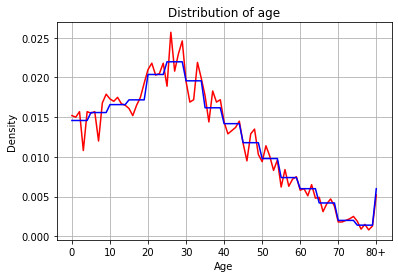

In [13]:
import matplotlib.pyplot as plt

plt.plot(individuals['age'].value_counts(normalize=True).sort_index(ascending=True), 'r')
plt.plot(age_distribution, 'b')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of age')
plt.grid(True)
plt.xticks(np.arange(0,81,10), np.concatenate((age_values[np.arange(0,71,10)], ['80+'])) )

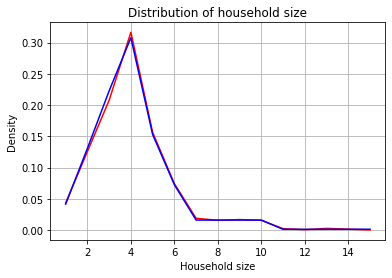

In [14]:
plt.plot(household_sizes, households['people staying'].value_counts(normalize=True).sort_index(ascending=True), 'r')
plt.plot(household_sizes, household_distribution, 'b')
plt.xlabel('Household size')
plt.ylabel('Density')
plt.title('Distribution of household size')
plt.grid(True)


([<matplotlib.axis.XTick at 0x7fe47a589f98>,
 [Text(0, 0, '1'),
  Text(0, 0, '10'),
  Text(0, 0, '100'),
  Text(0, 0, '1000'),
  Text(0, 0, '2400')])

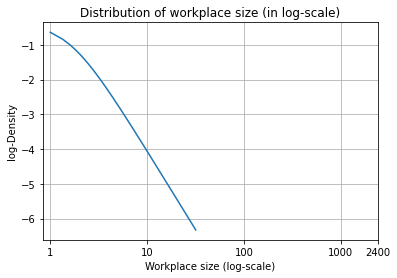

In [40]:
m_max = 2870
workplace_sizes = np.arange(m_max)

# WP_numbers = np.array([workplaces.loc[workplaces['capacity']==workplace_sizes[i]] for i in range(0,len(workplace_sizes))])
# WP_numbers = WP_numbers/sum(WP_numbers)

plt.plot(np.log10(workplace_sizes), np.log10(workplacesize_distribution))
plt.xlabel('Workplace size (log-scale)')
plt.ylabel('log-Density')
plt.title('Distribution of workplace size (in log-scale)')
plt.grid(True)
plot_xlabel =  [1, 10, 100, 1000, 2400]

plot_xlabel1 = np.log(workplace_sizes)[plot_xlabel]
plt.xticks(plot_xlabel1, (workplace_sizes)[plot_xlabel])
#plt.plot(np.log10(workplace_sizes), np.log10(workplaces['capacity'].value_counts(normalize=True)), 'r')

0       19
1       72
2        2
3        1
4        3
      ... 
119     17
120      1
121     61
122      2
123    120
Name: capacity, Length: 124, dtype: int64

In [17]:
workplaces

,ID,ward,lat,lon,location,capacity,workforce,workers,distances
0,7,90,12.987940,77.620287,"(77.62028678331403, 12.987940097756733)",19,19,"[6873, 5405, 6223, 87, 5712, 7449, 3309, 2014,...","[0.5008846042484054, 5.292661524717327, 3.5271..."
1,8,108,12.979553,77.558958,"(77.5589578954326, 12.979552940028066)",72,72,"[8504, 2746, 6303, 1216, 7557, 6304, 2536, 944...","[0.4033473898260889, 1.6277904311639793, 0.403..."
2,9,180,12.909255,77.567329,"(77.56732904157678, 12.909254563550252)",2,2,"[1436, 6551]","[28.476061773055363, 3.5834516501885454]"
3,10,184,12.884286,77.528333,"(77.52833275328211, 12.88428638349778)",1,1,[784],[2.9328211579376355]
4,11,193,12.868456,77.592299,"(77.59229858270686, 12.8684555568063)",3,3,"[5356, 5145, 6791]","[1.8345819207306253, 5.419735854885509, 18.228..."
...,...,...,...,...,...,...,...,...,...
119,126,71,13.008812,77.493844,"(77.49384412143756, 13.008811602887866)",17,17,"[4794, 3892, 4360, 7561, 514, 6956, 7596, 0, 2...","[3.770833834615993, 0.25805181292369966, 1.962..."
120,127,124,12.968059,77.547031,"(77.54703086583136, 12.96805923077217)",1,1,[5070],[9.823337848847231]
121,128,94,12.987403,77.582514,"(77.58251371306429, 12.987402599039843)",61,61,"[611, 1649, 3565, 2435, 5014, 2305, 464, 7244,...","[1.348922791427798, 6.961559235415328, 4.51787..."
122,129,149,12.917836,77.706521,"(77.70652102263784, 12.917836117997394)",2,2,"[130, 9635]","[3.4642727294793065, 1.4553357498477995]"
